# Minimal examples of how to use MSA


## Background

MSA stands for **"Multiperturbation Shapley value Analysis"** and as the name suggests, it's comprised of "multiple perturbations" and "Shapley value". Fundamentally, it uses a dataset of multi-element perturbation to estimate Shapley values of each element with respect to a global function. I'll refer you to these papers for technical and conceptual details:

- Keinan, Alon, Claus C. Hilgetag, Isaac Meilijson, and Eytan Ruppin. 2004. “Causal Localization of Neural Function: The Shapley Value Method.” Neurocomputing 58-60 (June): 215–22.

- Keinan, Alon, Ben Sandbank, Claus C. Hilgetag, Isaac Meilijson, and Eytan Ruppin. 2004. “Fair Attribution of Functional Contribution in Artificial and Biological Networks.” Neural Computation 16 (9): 1887–1915.

- Kötter, Rolf. 2007. “Shapley Ratings in Brain Networks.” Frontiers in Neuroinformatics 1 (NOV): 1–9.

- Toba, Monica N., Melissa Zavaglia, Caroline Malherbe, Tristan Moreau, Federica Rastelli, Anna Kaglik, Romain Valabrègue, Pascale Pradat-Diehl, Claus C. Hilgetag, and Antoni Valero-Cabré. 2020. “Game Theoretical Mapping of White Matter Contributions to Visuospatial Attention in Stroke Patients with Hemineglect.” Human Brain Mapping, no. February: 1–25.

- Zavaglia, Melissa, and Claus C. Hilgetag. 2016. “Causal Functional Contributions and Interactions in the Attention Network of the Brain: An Objective Multi-Perturbation Analysis.” Brain Structure & Function 221 (5): 2553–68.

The toolbox is designed to handle a large variety of systems. All it needs is a list of elements, let's say node labels, node indices, tuples (connections between nodes for examples), but I didn't really test things that are not networks! For example, if you're interested in explainable machine learning there's already a very versatile toolbox called SHAP that calculates the Shapley values of model's input features. MSA is traditionally used as a brain-mapping tool (I mean, just look at those papers) and I'm also a neuroscientist so there's a bias towards networks and lesion-mapping conceptualization. These said, let's see how MSA works using some small networks.

## Defining the network and the game


In [1]:
# Imports n stuff
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
#---------
import msa
import utils as ut
#---------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'GothamSSm'  # Will skip if you don't have Gotham typeface family
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 10
cm = 1/2.54

As mentioned, all MSA needs is a list of elements, that's not quite true tho it needs a game. Players (elements) should play the game and well, the game can be anything and in a way, that's the beauty of it. Here, I will define a game called "ge" that stands for "average global efficiency" (yeah it should be "age" but that would be weird!), which is a graph metric. See **[this page](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency)** for more detail.

So you need to define a game, a function that encapsulates the procedure you care about while the system is being lesioned. For example, if you're using MSA in the classic sense of brain mapping, the game function is where you perform the "cognitive experiment". Keep in mind a few things:

1. Take care of the edge-cases. MSA goes through all the possible ways you can lesion your system so if you're interested in the contribution (shapley value) of each node to information flow in a network, then in some of these combinations of lesions the network might end up with just a bunch of isolated nodes. Like define conditions, if len(x) < y return 0. 

2. Copy your stuff before feeding it to the toolbox. Otherwise (depending on how you're lesioning the system) it might leak to the next step and messes with everything.

3. The result should be "one value", a global measure that describes the system with one value.

In [2]:
def ge(complements, graph):
    if len(complements) < 0:
        # grand coalition is in, nothing to lesion so work with the intact network.
        return nx.global_efficiency(graph)
    
    elif len(complements) == len(graph):
        # everything is gone, why calling nx.global_efficiency?
        return 0.0

    else:
        # lesion the system, calculate global efficiency
        lesioned = graph.copy()
        lesioned.remove_nodes_from(complements)
        return nx.global_efficiency(lesioned)

Next, I'll make a graph with an intuitive topology, i.e., a balanced tree. Intuitively, the farther we go from the root, the smaller shapley values we will have. It's possible that the outer branch ends with negative shapley values since removing them shortenes the overal paths and improves global efficiency.

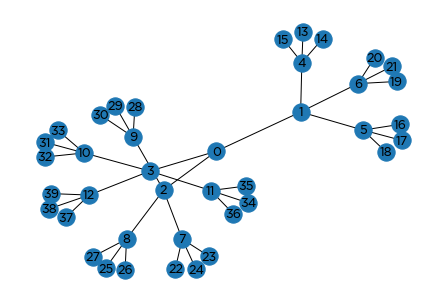

In [3]:
G = nx.balanced_tree(3,3)
nx.draw(G,with_labels=True)

## MSA in action
Briefly, we'll estimate shapley values by first permuting the elements N times, then producing an instruction for which combinations to lesion.

In [4]:
node_perms = msa.make_permutation_space(elements=list(G.nodes), n_permutations=1_000)
print(np.shape(node_perms))
print(f'Nodes: {list(G.nodes)}\n')
print(f'Permuted nodes: {node_perms[0]}')

(1000, 40)
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

Permuted nodes: (6, 37, 0, 38, 25, 30, 11, 28, 24, 16, 18, 36, 8, 7, 12, 5, 31, 15, 26, 35, 19, 2, 10, 17, 3, 23, 1, 34, 20, 32, 21, 27, 22, 13, 4, 39, 14, 9, 33, 29)


In [5]:
node_combs_template = msa.make_combination_space(permutation_space=node_perms)
node_compl_template = ut.make_complement_space(combination_space=node_combs_template, elements=list(G.nodes))
print(f'Number of lesion combinations: {len(node_combs_template)}')


Number of lesion combinations: 36091


Here we use the parallelized_take_contributions to actually play games and fill the values. We then use this multi-site perturbation dataset to calculate shapley values and sort them.

In [6]:
global_eff,_ = ut.parallelized_take_contributions(complement_space=node_compl_template,
                                                  combination_space=node_combs_template,
                                                  objective_function=ge,
                                                  objective_function_params={'graph': G})

In [7]:
global_eff_shapley = msa.make_shapley_values(contributions=global_eff, permutation_space=node_perms)
global_eff_shapley = ut.sorter(global_eff_shapley)
global_eff_shapley.head()

,37,23,18,25,16,29,38,36,20,31,...,6,8,12,4,10,5,3,2,0,1
0,0.000000,0.001598,0.000000,0.000000,0.000000,-0.001950,0.000000,0.015152,-0.001659,-0.007843,...,0.000000,0.010490,0.019414,0.028139,-0.003764,0.014286,0.088077,0.031602,0.000000,0.084676
1,-0.004902,-0.002833,0.002255,-0.009589,0.002490,0.008741,-0.000830,-0.008791,0.002203,-0.001161,...,0.004887,0.038633,0.000000,0.047024,-0.010989,0.000000,0.010757,0.008878,0.123906,0.066667
2,-0.004162,0.003309,-0.008987,0.033730,0.000000,0.004128,-0.013304,-0.002092,0.003262,0.001716,...,0.041667,0.000000,-0.004077,0.021757,-0.017483,0.038877,0.110953,0.094499,0.002047,0.000000
3,0.000000,-0.008246,-0.016008,-0.000997,-0.006410,0.000000,-0.013889,-0.002031,-0.001950,0.000000,...,0.032357,0.000000,0.038705,0.006993,0.004837,0.039493,0.058059,0.069444,0.000000,0.042123
4,0.000000,-0.005354,0.000000,0.000000,0.001983,0.000000,0.000000,-0.005263,0.002780,-0.003859,...,0.000000,0.007393,0.027473,0.000000,0.021328,0.002326,0.054987,0.115315,0.000000,0.037375


Text(0.5, 1.0, 'Contribution of each node to the Global efficiency')

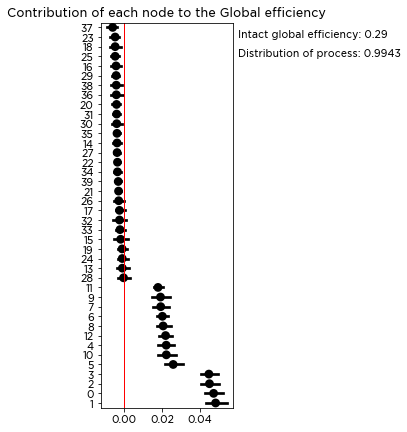

In [8]:
intact_global_eff = nx.global_efficiency(G)
d_global_eff = ut.distribution_of_processing(shapley_vector=global_eff_shapley.mean())

plt.figure(figsize=(6*cm,18*cm))
sns.pointplot(data=global_eff_shapley,ci=95, join=False,orient='h', color='k')
plt.axvline(linewidth=1, color='r')
plt.text(0.06, 1,f'Intact global efficiency: {intact_global_eff:.2f}')
plt.text(0.06, 3,f'Distribution of process: {d_global_eff:.4f}')
plt.title("Contribution of each node to the Global efficiency")

Voila! Minimal example.
p.s: Sum of all the shapley values will add up to the value you get if you run the analysis on the intact network (grand coalition). It's a nice sanity check. Here:

In [9]:
print(intact_global_eff-global_eff_shapley.mean().sum())

0.0


Of course this might not be the case if there are stochasticity in the results. But in that case too, it should not be very far. 